# **INDIVIDUALITY - IMPORTING PACKAGES & DATA**

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 16.1MB/s 
     |████████████████████████████████| 3.0MB 24.1MB/s 
     |████████████████████████████████| 890kB 29.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=90e088d6f8cd52fb0648a6383aa757083af670c2ec9c3ac3483d4fb8285ac40f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
import transformers
# per the setting of transformers, to use any of its NLP model
# we need to have three things: that is BertTokenizer, BertModel, BertConfig
from transformers import BertTokenizer, BertModel, BertConfig

In [3]:
# first, let's see if we have GPU so that we could train our model in GPU
# GPU is really at parallel computation
from torch import cuda
if torch.cuda.is_available():
  device = torch.device('cuda')
  print(device)


cuda


In [4]:
# collect Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# create an instance of BERT model 
# note that it takes time to download the BERT model (~ 440M)
# BERT model is big, because it has a lot of paramters. 
model = BertModel.from_pretrained('bert-base-uncased')

In [6]:
# creat an instance of BERT tokenizer
# as you can tell, the tokenizer is pretty small, only 232k in size
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
import pandas as pd
import numpy as np

url = 'amazon_data.csv'
raw_review = pd.read_csv(url)
raw_review

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,social connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health,Unnamed: 29
0,3525027,US,3145405,R1Y9RICO8ZJ81Y,B008TV4BTI,324530391.0,BOSS HUGO BOSS Men's Starfish Swim Trunk,Apparel,4,0,0,N,N,Good quality,"The quality is good, fits good but I didnt pay...",2014-06-23,0,0,0,0,0,1,0,0,0,1,0,0,0,NaN
1,5120532,US,67557,R1KSZIZUI25LXF,B002JLFMLK,109099956.0,Vedette Megane Firm Compression Sensual Corset...,Apparel,4,1,2,N,Y,I like this bodyshaper.,This body shaper does what it says. It makes y...,2013-09-01,0,0,0,0,0,1,0,0,0,1,0,0,1,NaN
2,523451,US,13232823,RK6JCVD27KHG5,B00OO1GHLM,600113027.0,Adult Stilinski 24 Beacon Hills Lacrosse 2-Sid...,Apparel,5,0,0,N,Y,Nice hoodie,It looks well made. I bought it for my grandd...,2015-08-03,1,0,0,0,0,0,0,0,0,1,0,0,0,NaN
3,3620630,US,10055103,R3HZ4WB8L7URPG,B008G7JOBA,381781741.0,Carhartt Men's Sherpa Lined Sandstone Hooded M...,Apparel,5,3,3,N,Y,Size Small Means Medium,Other than the sizing that is bigger than the ...,2014-10-02,0,0,0,0,0,0,0,0,1,1,0,0,1,NaN
4,2464514,US,15251195,R1MTD681OUV0K9,B00DUK7SLQ,571539834.0,Roxy Juniors Gallery Backpack,Apparel,5,0,0,N,Y,Five Stars,Love my backpack.,2014-09-15,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1654,85384,US,4752121,R29BY4XZPERCRE,B00AMFTLLW,660000000.0,Virus Removal Service - Jupiter Support,Software,5,0,0,N,N,IE issue,i just got done with jupiter on i script prob ...,4/26/2014,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
1655,200758,US,22733472,R3THOGV2C7919H,B0041DTNI2,474000000.0,Family Tree Maker 2011 Deluxe [Old Version],Software,3,1,2,Y,N,Not for use on a netbook,I used this software on my netbook and it divi...,9/23/2011,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
1656,230985,US,14537207,R2UNXHF3TG8YKM,B001BSGC3Y,834000000.0,"Learn Italian: Fluenz Italian 1 for Mac, PC, i...",Software,5,2,2,N,N,awesome program,"hi, Just want to say it what a great company! ...",4/30/2010,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN
1657,262294,US,50325594,R1I59RZ3O0O36Z,B0018EI3I8,852000000.0,Kaspersky Internet Security 2009 (3 User),Software,5,0,0,N,Y,Great product,Great internet security product. I guess the b...,12/22/2008,0,0,0,0,0,0,0,0,0,1,0,0,0,NaN


In [ ]:
train_review = pd.DataFrame(None)

train_review[['text','label']] = raw_review[['review_body','individuality']].iloc[0:1661,:]

In [ ]:
train_review = train_review.dropna()

In [ ]:
train_review.describe()

,label
count,1658.000000
mean,0.142943
std,0.350121
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# **First Test - No Augmentation**

## Define a Customized Dataset Class and Setup the Dataloader



In [19]:
# first let's define some key parameters we will use later
# note this is a relatively large number, making the training process slow, 
# but it's necessary becuase a lot of reviews are long.
max_length = 128
# how many raw inputs we feed into the train and validation model at once
train_batch = 32
valid_batch = 32

In [20]:
# then we need to import the libraries we need
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [21]:
class AmazonDataset(Dataset):

  # here we want to  create a customized dataset--YelpDataset--which could take a raw text as input
  # and encode it in BERT's way with a tokenizer. 
  # The tokenized input will be then fed into a BERT Model in the NN, which we will create later

  # __init__ defines some necessary attributes for any instance created
  # like: the dataset with raw text reviews, what tokenizer we want to use for encoding, 
  # the max length of sentence we need to pad or trancate
  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len
  

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    # __getitem__ take index as input, 
    # in general/without customizatin, it returns the sample with the index in the dataset
    # further we could customize its functionality, letting it to apply some operations on the 
    # index-specified sample before return a value for us
    # here we use index to locate a specific review text we want to pre-process
    # text = str(self.text[index])
    # text = " ".join(text.split())
    text = self.text.iloc[index]

    # then, we put the text into a BERT encode_plus
    # important debug tips: 
    # for encode_plus, to keep all the raw inputs in the same lenght
    # we need to specify BOTH padding and trancation in addition to max_length
    # the former for short sentences and the latter for long ones
    # failing to do either one will result in uneven lengths of encoded inputs,
    # which will create troubles for your dataloader in the nn training sessions
    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        # note that in some versions of transformer in you local machine, the code is 
        # pad_to_max_length = True,
        # truncation_strategy = 'longest_first',
        # we might need to change the argument name a little to fit different version of transformers
        add_special_tokens = True,
        return_tensors = 'pt'
    )
    # recall the BERT Tokenizer session, it takes raw text as input
    # and return input_ids, attention_mask
    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    # we then store those values and put them together with the label info in the sample
    # as the return of the __getitem__ method
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float) 
    }



In [ ]:
# split the train and validate dataset
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(train_review, test_size = 0.1)

In [ ]:
# create instances of the YelpDataset for raw trianing and validate datasets
# recall that tokenizer has be defined by: tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') in the BERT tokenizer session
train_processed = AmazonDataset(train_raw, tokenizer, max_length)
valid_processed = AmazonDataset(valid_raw, tokenizer, max_length)

In [ ]:
# check the attributes and method of train_processed
train_processed.__len__()

1492

In [ ]:
# test the customized Dataset instance
print(train_processed.__getitem__(10))

{'input_ids': tensor([[  101,  2515,  2054,  2003,  3517,  1997,  2019, 10751,  4328,  5830,
          1012,  2081,  1997,  2204, 23073,  3430,  1010,  2004,  2092,  2004,
         23073,  9127,  2015,  1006,  2073,  5830,  6010,  2132, 19400,  1007,
          1012,  6749,  8192,  1999,  2422,  3293,  2030,  5647,  5097,  1012,
          2053, 10821,  2061,  2521,  1012,  2031,  3641,  2122,  1999,  2536,
         10742,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# see the dimension of the pre-processed data
print(train_processed.__getitem__(10)['input_ids'].shape)
# we can use the squeeze() method to remove the axis of "1", a method we will use later
print(train_processed.__getitem__(10)['input_ids'].squeeze().shape)

torch.Size([1, 128])
torch.Size([128])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# important, run it again to create a new dataset loader for every NN model you train
# lastly, set up the dataloader that serves as a pipeline feeding pre-processed data into the neural network
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, batch_size = valid_batch, num_workers = 0)

In [ ]:
# exploer the attributes of dataloder
# length of dataloader = len(dataset)/batch size
print(len(train_loader))
print(len(valid_loader))


47
6


## Define a Customized Neural Network with the First Hidden Layer as NLP Encoding Layer


Up to now, we have defined the customized Dataset class that preprocess the raw input, encoding them into input_ids and attention_mask that BERT model needs. We also set up the Dataloader that feed the pre-processed data into the Neural Network we are creating now. 

In [9]:
# import the functions we need use in the Netwrok Model
import torch.nn.functional as F

In [10]:
# the neural network we create is a class called  YelpBERT, which inherits
# the attributes and structures of the torch.nn.Module

# the __init__ functino defines the necessary hidden layers of the NN
# and the forward function set up the computation graph: the real calculation procedures of the NN
# see the class session 7's slides and recording for details 

class AmazonBERT(torch.nn.Module):
  def __init__(self):
    super(AmazonBERT, self).__init__()
    # recall that, we have defined model as: model = BertModel.from_pretrained('bert-base-uncased')
    # see BERT Model's input and output: https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    self.l1 = model

    # with this layer a percentage of all neurons will be randomly turned-off to prevent overfitting
    # since our training dataset might be small, we really cannot afford a large neural network
    # the output of the BERT layer is a vector of 768 elements, if fully connected to next linear layer
    # then the current layer would have 768 neurons, too much! 
    # using dropout mechanism, we can randomly turn off a percentage of the neuraon in the training process
    # literally reduced the number of neuron in the layer
    self.l2 = torch.nn.Dropout(0.5) 

    # if you want to have multiple fully connected linear layer, use this
    # self.l2 = torch.nn.Linear(768, 10)
    # but again, if your training dataset is not very large, we may only offard one linear layer
    
    # last layer
    self.l3 = torch.nn.Linear(768, 1)


  
  def forward(self, input_ids, attention_mask):
    # first layer
    # the first layer utilize the BERT model (call "model" in __init__) to transfer the input_ids into
    # contextualized word embeddings --numerical vectors
    # we can customize the output of this layer such as using the [CLS] token or the mean of all input tokens
   
    # if you want to use the BERT output of the last self-attention layer, use this:
    last, pooler = self.l1(input_ids = input_ids, attention_mask = attention_mask)
   
    # if you want to use BERT output from OTHER self-attention layers,use this:
    # (note that BERT base model has 12 hidden self-attention layers), 
    # last, pooler, all = self.l1(input_ids = input_ids, attention_mask = attention_mask, output_hidden_states = True)
    
    # second layer
    # here we could use the mean value of tokens of all raw inputs as the embedding of the whole input text
    # and feed it into the second layer, use this: 
    # output from last BERT self-attention layer:
    # initial index "0" for mean value of [cls] token and all non-padded tokens
    # initial index "1" for mean value of all non-padded tokens only
    output = last[:, 0 : attention_mask.sum(), :].mean(dim = 1)
    # BERT output from other hidden self-attention layer:
    # output = all[11][:, 0 : attention_mask.sum(), :].mean(dim = 1)
    
    # or use the [CLS] token of last layer
    # output = last[:, 0, :]

    # output from BERT model now be fed into a relu activation funcation adn
    # the second layer of the Neural Network
    output = F.relu(output.squeeze())
    output = F.relu(self.l2(output))

    # why squeeze(): to make the dimension of input-output across layers consistent
    # e.g., the output of layer 1--self.l1, is in the shape of (1, 768),
    # we use .squeeze() to make it in a shape of (768) only, 
    # because the later layer--l2 adn l2--take (768) as input dimension not (1, 768)

    # third layer
    output = self.l3(output)

    # last sigmoid layer to furhter transfer the single scalar of l3 into a probability
    return torch.sigmoid(output)
    # note that we can also customize the layers after the 1st one, 
    # making more layers (i.e., a deeper NN) and see if it perform betters 

In [ ]:
# test the model step-by-step
# compare the output dimension to your expectation
# https://huggingface.co/transformers/model_doc/bert.html#bertmodel
# testing each layer in the NN is very important
# we should pay close attention the the dimensions of the inputs and outputs of each layer 
# use .squeeze() to remove uncessary axis whose length is 1 to make the dimensions consistent. like "output = pooler.squeeze()" in the NN above
l1 = model
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last, pooler = l1(input_ids = input_ids, attention_mask = attention_mask)
print(last.shape)
print(last.squeeze().shape)
print(pooler.shape)
print(pooler.squeeze().shape)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


torch.Size([1, 128, 768])
torch.Size([128, 768])
torch.Size([1, 768])
torch.Size([768])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# similarly, test if the dimensions of input and output 
output = last[:, 1 : attention_mask.sum(), :].mean(dim = 1)
output = output.squeeze()
output.shape
l2 = torch.nn.Dropout(0.5)   
l2.to(device)
l3 = torch.nn.Linear(768, 1)
l3.to(device)
output.to(device)
l3(l2(torch.tensor(output)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


tensor([-0.2254], device='cuda:0', grad_fn=<AddBackward0>)

## Create a BERT + NN Model as an Instance of the Customized Model Classs Defined Above and Setup the Loss Function and Optimizer


In [11]:
# create an instance of the YelpBERT model
# remember to recreat a instance of the Model Class after you modified the YelpBERT class
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
# test the model_yelp
# recall that the train_processed is a special class that could pre-process the raw input words into input_ids
# and attentino_mask using its method __getitem__ method
# we then use this method to get the input_ids and attention_mask that we need to feed in the YelpBERT() model

test_output = model_amazon(input_ids, attention_mask)
print(len(test_output))
print(test_output)
# note that the output is a scalar, becasue ofthe last hidden layer in the NN, self.l3 = torch.nn.Linear(768, 1)
# the scalar then can be put into a softmax for prediction 


1
tensor([0.4756], device='cuda:0', grad_fn=<SigmoidBackward>)


In [ ]:
print(input_ids.shape)
print(attention_mask.shape)


torch.Size([1, 128])
torch.Size([1, 128])


In [ ]:
# check out the model parameters
# note that the first BERT layer, the word embeddings are in the shape of (30522, 768)
# and we can tell that the first 12 layers of our model are normal BERT layers, 
# the last two are what we customized-- a dropout layer and the linear layer
model_amazon.parameters

<bound method Module.parameters of AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=

Up to now, we have the Dataset (pre-process/encode the raw text inputs, making them into input_ids that BERT model takes as input), the Dataloader (feed the processed data into the NN in batchs), the neural network (with the first layer as a BERT model, the transfer the encoded input_ids into word embeddings, and later layers just work on those embeddings/numerical vectors as normal neural network). 

And finally, we could set up our training loops

First we start with: the loss function (e.g., crossentropy loss or mean squared error loss) and the optimize schedule (some thing about learning rate, adaptive learning rate, see class 7)

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
# criterion is the loss function we use
# here we use Binary CrossEntropy Loss, you can try others see the performance difference
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = nn.BCELoss()
# note that loss function in pytorch framework usually take the pair of (prediction, ground_truth) as input
# and give the loss value as output

In [ ]:
# optimizer is our optimize strategy, here we use stachastic gradient descending as the approch 
# to update our model parameters. 
# tips: previously I trained multiple models but with learning rate = 1e-05, 3e-05, 
# after 4 epochs the model performance almost doesn't change
# thus now I use 10e-05, it seems the performance improves faster
learning_rate = 10e-05
# SGD is a common optimizer, but let's use Adam here, AdamW is a optimizer developed by Huggingface using Adam's mechanism
# optimizer = optim.SGD(model_yelp.parameters(), lr = learning_rate, momentum = 0.9)
# http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
# you can try out other optimization method and see performance difference

In [ ]:
# set the epoch
epochs = 3
# epochs means how many rounds each training sample will be fed into the NN.
# next, we need to supply our model "model_yelp" to the GPU, so it can be run on GPU
# model_yelp.to(device)
# since the GPU has a lot of cores, it takes some time to supply to model to the GPU


In [ ]:
# try another optimizer
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_amazon.parameters(),lr = learning_rate,eps = 1e-8)
                  
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler that update the learning rate gradully, this scheduler is with AdamW
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
# lastly, let's define a helper function we can use for calculating the prediction accuracy
import numpy as np
# the idea of the funtion is that a vector of predicted probablity of being good review, 
# which is the output of the sigmoid/last layer of the neural network, is compared with the true label
# is the predicted probability >= 0.5, we assign 1, otherwise we assign 0, we use np.around() achieve this
def pred_accuracy (prediction, label):
  pred_flat = np.around(prediction).flatten()
  label_flat = label.flatten()
  return np.sum(pred_flat == label_flat) / len(label_flat)


## Train the BERT + NN Model and Evaluate the Performance

In [ ]:
# set the random set the same, making the results reproducible
import random
seed_val = 45
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

OK, finally, we strat to train the model

In [ ]:
# create an instance of the YelpBERT model
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
# set up the directory for storing the trained model
import os
# save to Google Drive
dir = "/content/drive/My Drive"
# save to local file
# dir = "E://OneDrive - lmu.edu//Python Projects//BERT and ML"


In [ ]:
# Very Important: Each Time When You Train a Neural Network Again, 
# Plase recreate the nural network, the dataloader, and the optimizer and its scheduler.


# train the model 
# store the total loss and accuracy values of each epoch
training_stats = []

# the epoch loop, number of rounds specified by epochs
for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))
  # zero the values of total loss and accuracy of the epoch
  total_loss = 0
  total_accuracy = 0
  # in the training stage, set the model into train mode
  model_amazon.train()

  # the training step loop
  # recall that train_loader feed data into the NN in batchs to save memory and improve efficiency
  # then the # of total steps is about (# of samples/batch size)
  print("training")
  for step, batch in enumerate(train_loader, 0):
    # feed the data into GPU using .to(device) method
    # note that the input_ids for one raw input is in the shape of (1, max_length)
    # after be processed into batch, the input_ids become (batch_size, 1, max_length)
    # however, BERT only takes input_ids in the shape of (batch_size, max_length),
    # (see here: https://huggingface.co/transformers/model_doc/bert.html#bertmodel)
    # so we need to do "batch['input_ids'].squeeze()" inestead of "batch['input_ids']"
    # to remove the unnecessy axis of "1". 
    # same operation for attention_mask
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    # at each step, before the NN does the feed forward, let's set the gradient to 0
    # as pytorch nn.Module automatically cumulates gradient from previous rounds
    # this is good for RNN training, but not necessy for us here. Thus, we turn it off.   
    optimizer.zero_grad()
    
    # for each raw input, the feed forward calculation give us two scalar, 
    # representing the score/probability of the sample being 0/bad review class or 1/good review class  
    # note that since we feed the inputs/raw samples in batch, 
    # the prediciton should be in the shape of (batch_size, # of classes)
    prediction = model_amazon(input_ids, attention_mask)
    prediction = prediction.squeeze()

    # criterion is defined as a cross entropy loss function
    # it takes (prediction, ground truth) as input arugments
    # the former should be in the shape of (batch_size, # of classes), 
    # the latter should be in the sahpe of (batch_szie, 1), "1" dimension records the true class id of the input
    # https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html   
    loss = criterion(prediction, label)

    # with the loss, we can do back propagation to calculate the gradient
    # very easy, just one line of code  
    loss.backward()

    # with the gradient, we can update the model paramters. 
    # recall how we define the optimizer in the above cell  
    optimizer.step()
    
    # update the learning rate
    scheduler.step()

    # to keep tracking on the model performance, we accumulate the total loss in every epoch  
    total_loss += loss.item()
      
    # for every 10 steps, we print out the epoce # and loss
    # again, the max_length of raw text input is 256, relatively long than usual, thus it will take longer to train. 
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')
  
  # calcualte and store the average training loss of each batch in the current epoch
  avg_train_loss = total_loss / len(train_loader)

  

  # now let's set up the validation loop, meaning the trained model above will be used to evaluate the sample in validation dataset
  # note that this validation loop is in the same "indent" level as the training loop, and they both under the epoches loop
  print("validating")
  # set the model now in the evaluation mode
  model_amazon.eval()
  # zero the values of total loss and accuracy
  total_loss = 0
  #total_accuracy = 0

  # validation loop
  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = model_amazon(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  # calcualte and store the average training loss of each batch in the current epoch
  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )
  


  # lastly, at the end of each epoch, let's save the model for later use
  # note that dir is defined before as "./content/drive/My Drive"  
  torch.save(model_amazon.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")



======== Epoch 1 / 3 ==========
training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1, Total_Loss:4.845832705497742, Average_Loss:0.4845832705497742
Epoch:1, Total_Loss:8.847078263759613, Average_Loss:0.4423539131879807
Epoch:1, Total_Loss:12.067029416561127, Average_Loss:0.4022343138853709
Epoch:1, Total_Loss:16.273745954036713, Average_Loss:0.40684364885091784
validating
======== Epoch 2 / 3 ==========
training
Epoch:2, Total_Loss:3.5903151482343674, Average_Loss:0.35903151482343676
Epoch:2, Total_Loss:6.345460370182991, Average_Loss:0.3172730185091496
Epoch:2, Total_Loss:8.841391257941723, Average_Loss:0.29471304193139075
Epoch:2, Total_Loss:11.756009541451931, Average_Loss:0.29390023853629826
validating
======== Epoch 3 / 3 ==========
training
Epoch:3, Total_Loss:2.1857331469655037, Average_Loss:0.21857331469655036
Epoch:3, Total_Loss:3.6037601940333843, Average_Loss:0.1801880097016692
Epoch:3, Total_Loss:4.944016370922327, Average_Loss:0.1648005456974109
Epoch:3, Total_Loss:6.323442440479994, Average_Loss:0.15808606101199985
validating
training complete!


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


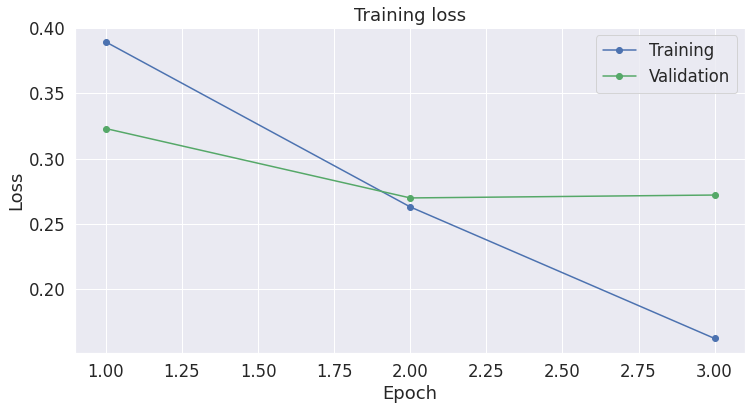

In [ ]:
# plot the train statistics stored in training_stats
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# make sure to save the model performance statistics and the associated model configuration. 
# that is save the df_stats to csv file with a file name, say experiment 1
df_stats.to_csv(os.path.join(dir, 'label_experiment_individuality_stats.csv'))
# save the key hyper-parameters of this training experiment, say experiment 1
label_experiment_individuality = {
    "epochs": epochs,
    "train_batch_size" : train_batch,
    "valid_batch_size" : valid_batch,
    "initial_learning_rate": learning_rate,
     "max_sentence_length": max_length,
     "loss_fucntion": criterion,
     "optimizer": optimizer,
     # you need to manually type-in the following info
     "BERT output": "mean value of [cls] embeddings of non-padded token from the second to the last layer",
     "activation function": "relu",
     "dropout rate of BERT output": model_amazon.l2,
     "# of fully connected linear layer": 1,
     "dataset": "Amazon First Test",
     "comment": "Since when we run with 10 epochs the model was overfitting, we decided to run until epoch 3, where the overfitting problem was not occurring."
}


In [ ]:
# save the experiment configurate assocaited with this experiment
# note that if you click the file icon (the third vertical one on the far left)
# you will see the save files, double click on them, you can see them.
import csv
with open(os.path.join(dir, 'label_experiment_individuality_config.csv'), 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in label_experiment_individuality.items():
       writer.writerow([key, value])

## Evaluate the Model Performance

In [ ]:
# apply the trained model to the validation dataset
# get the model predictions and compare the comparisons to the true labels
model_amazon.eval()
predictions, labels = [], []
for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    prediction = model_amazon(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
# call the helper function-- pred_accuacy to compute the prediction accuracy in each batch
ac = []
for i in range(len(predictions)):
  ac_i = pred_accuracy(predictions[i], labels[i])
  ac.append(ac_i)
ac

[0.96875, 0.90625, 0.84375, 0.875, 0.9375, 1.0]

In [ ]:
# transfer the outcomes into np
predictions = np.asarray(predictions)
labels = np.asarray(labels)
predictions[0]
# note that now the outcomes are still stored in batches

array([[0.01643513],
       [0.01501781],
       [0.02555622],
       [0.01278379],
       [0.01164631],
       [0.01558288],
       [0.05309209],
       [0.01900916],
       [0.65378845],
       [0.05243885],
       [0.01245791],
       [0.28878292],
       [0.8793903 ],
       [0.0125807 ],
       [0.06818998],
       [0.09009968],
       [0.01303282],
       [0.01262521],
       [0.01264772],
       [0.7929475 ],
       [0.01231922],
       [0.50653756],
       [0.01357864],
       [0.01647096],
       [0.01185927],
       [0.8936077 ],
       [0.0456352 ],
       [0.01201822],
       [0.2297361 ],
       [0.01173183],
       [0.02123696],
       [0.01385682]], dtype=float32)

In [ ]:
# convert predictions stored in the batches into a long vector
pred = np.concatenate(predictions, axis=0 )
pred = np.concatenate(pred, axis=0 )
pred = pred.reshape(len(pred),1)
print(pred.shape)

(166, 1)


In [ ]:
# convert the true labels batches into a long vector
true_label = np.concatenate(labels, axis=0 )
true_label = true_label.reshape(len(true_label), 1)
print(true_label.shape)
type(true_label)

(166, 1)


numpy.ndarray

In [ ]:
# put the predictions and labels into the same dataset
df = np.concatenate([pred, true_label], axis = 1)
df = pd.DataFrame(data=df, columns=["preds", "labels"])
df

,preds,labels
0,0.016435,0.0
1,0.015018,0.0
2,0.025556,0.0
3,0.012784,0.0
4,0.011646,0.0
...,...,...
161,0.013264,0.0
162,0.016308,0.0
163,0.015764,0.0
164,0.012046,0.0


In [ ]:
# see the total prediction accuracy
sum((df["preds"]>=0.5) == df["labels"])

160

In [ ]:
# find the index of the review that has the lowest predicted probabilty(of being a positive review) in true_label == 1 group. 
df.loc[df.loc[df['labels'] == 1, :].idxmin()]

,preds,labels
63,0.147236,1.0
8,0.653788,1.0


In [ ]:
# see that review
valid_raw.iloc[63,0]


'I agree with most of the other reviewers here, Easy Media Creator 7 is a great product. It installed fine - albeit slowly - and has performed without a problem since day one. Over the first couple of months of use, I had a couple of questions that I emailed to Roxio\'s customer support and they were quick to get back to me with answers. Overall it was easy to learn; even my wife and kids use it regularly. We use all aspects of the product and give it a big \\\\"thumbs up\\\\" rating and recommend it to everyone. We even bought another copy of it and gave it away as a present to my brother and his family out on the west coast. Now we can easily create and share family pictures, movies and projects with one another. It\'s actually turned into a little sibling rivalry as to who can outdo the other.'

In [ ]:
# alternatively, for all the reviews that have true_label == 1, 
# let's sort their predicted probabilities
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
63,0.147236,1.0
11,0.288783,1.0
130,0.319570,1.0
104,0.350563,1.0
41,0.399533,1.0
21,0.506538,1.0
80,0.639127,1.0
8,0.653788,1.0
102,0.774862,1.0
19,0.792947,1.0


In [ ]:
df[df['labels']==1].preds.sort_values()[0:20]

21     0.012464
28     0.017698
101    0.024938
50     0.035331
147    0.040688
14     0.065774
77     0.070387
158    0.099268
121    0.258026
11     0.288783
52     0.306653
54     0.399533
12     0.552380
13     0.665488
128    0.694615
89     0.732592
36     0.809011
92     0.809551
88     0.827041
26     0.844706
Name: preds, dtype: float32

In [ ]:
valid_raw.iloc[85,0]

"I get a lot of compliments on this dress. A woman who was in her car stopped even rolled her window down to say cute dress! It's so retro and adorable. I wear it with a little pink cardigan and nude suede flats. Someone else described it as &#34;very Anthropologie&#34; if you've ever shopped there, and it is for sure. The quality is very good. It's lined. I bought it during one or the eShakti Amazon sales. This is my 4th eShakti dress and they're all great."

In [ ]:
# see the reviews
valid_raw.iloc[28,0]

'These work great. I have tried others and always come back to Affresh. We use once a month to maintain a fresh washer.'

In [ ]:
# on the other way around, for all the reviews whose label == 0, 
# let's sort their predicted probablities in descending order
df[df['labels'] == 0].sort_values('preds', ascending = False)

,preds,labels
140,0.669559,0.0
150,0.455252,0.0
60,0.317536,0.0
62,0.233301,0.0
28,0.229736,0.0
...,...,...
84,0.011564,0.0
142,0.011554,0.0
138,0.011533,0.0
146,0.011463,0.0


In [ ]:
# see the reviews
# after learning some examples, it seems that our model will give a high score as long as the food is good
# even though the service is not. 
valid_raw.iloc[56,0]

'My 4 year old wore this for Halloween and it was a huge hit.... and he was absolutely adorable!'

In [ ]:
valid_raw.iloc[75,0]

'Product is simple and cute.  Sewing of layers was somewhat loose but still usable.  Would recommend to my friends to purchase.'

In [ ]:
valid_raw.iloc[102,0]

'after installing these lights ( which is so easy) being a plug n play to the cigarette lighter. i love the blue color that illuminates inside my car. i also get endless comments when at the store or gas station. i think everyone should have these inside there car. not only does it look good but it gives you the perfect amount of light inside the cab of ur vehicle that if u drop something its easier to find then turning on the interior lights which can be not only a hazard to yourself but to other drivers on the road. thanks for making this product so easy to install and to use. i will be buying more in the near future for some close family members who want them too'

# **Second Test - Augmentation(decreased performance)**

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
url='data_old_amazon_reviews.csv'

In [ ]:
raw_review=pd.read_csv(url)
raw_review

,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,social connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health
0,BOSS HUGO BOSS Men's Starfish Swim Trunk,Apparel,4,0,0,N,N,Good quality,"The quality is good, fits good but I didnt pay...",6/23/2014,0,0,0,0,0,1,0,0,0,1,0,0,0
1,Vedette Megane Firm Compression Sensual Corset...,Apparel,4,1,2,N,Y,I like this bodyshaper.,This body shaper does what it says. It makes y...,9/1/2013,0,0,0,0,0,1,0,0,0,1,0,0,1
2,Adult Stilinski 24 Beacon Hills Lacrosse 2-Sid...,Apparel,5,0,0,N,Y,Nice hoodie,It looks well made. I bought it for my grandda...,8/3/2015,1,0,0,0,0,0,0,0,0,1,0,0,0
3,Carhartt Men's Sherpa Lined Sandstone Hooded M...,Apparel,5,3,3,N,Y,Size Small Means Medium,Other than the sizing that is bigger than the ...,10/2/2014,0,0,0,0,0,0,0,0,1,1,0,0,1
4,Roxy Juniors Gallery Backpack,Apparel,5,0,0,N,Y,Five Stars,Love my backpack.,9/15/2014,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656,Virus Removal Service - Jupiter Support,Software,5,0,0,N,N,IE issue,i just got done with jupiter on i script prob ...,4/26/2014,0,0,0,0,0,0,0,0,0,1,0,0,0
1657,Family Tree Maker 2011 Deluxe [Old Version],Software,3,1,2,Y,N,Not for use on a netbook,I used this software on my netbook and it divi...,9/23/2011,0,0,0,0,0,0,0,0,0,1,0,0,0
1658,"Learn Italian: Fluenz Italian 1 for Mac, PC, i...",Software,5,2,2,N,N,awesome program,"hi, Just want to say it what a great company! ...",4/30/2010,0,0,0,0,0,0,0,0,0,1,0,0,0
1659,Kaspersky Internet Security 2009 (3 User),Software,5,0,0,N,Y,Great product,Great internet security product. I guess the b...,12/22/2008,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
train_review = pd.DataFrame(None)

train_review[['text','label']] = raw_review[['review_body','individuality']].iloc[0:1661,:]

In [ ]:
train_review=train_review.dropna()

In [ ]:
train_review.describe()

,label
count,1660.000000
mean,0.142771
std,0.349945
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## Define a Customized Dataset Class and Setup the Dataloader

In [ ]:
max_length = 128
train_batch = 32
valid_batch = 32

In [ ]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

In [ ]:
class AmazonDataset(Dataset):

  def __init__(self, dataset, tokenizer, max_len):
    self.tokenizer = tokenizer
    self.data = dataset
    self.text = dataset.text
    self.label = dataset.label
    self.max_len = max_len
  

  def __len__(self):
    return len(self.text)


  def __getitem__(self, index):
    text = self.text.iloc[index]

    outputs = self.tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        padding = "max_length",
        truncation = "longest_first",
        add_special_tokens = True,
        return_tensors = 'pt'
    )

    input_ids = outputs['input_ids']
    attention_mask = outputs['attention_mask']
    
    return {
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'label': torch.tensor(self.label.iloc[index], dtype = torch.float) 
    }

In [ ]:
from sklearn.model_selection import train_test_split
train_raw, valid_raw = train_test_split(train_review, test_size = 0.1)

In [ ]:
train_raw

,text,label
222,"Beautiful nightgown, love the colored flower d...",1
1188,"Easy Install, looks great!",0
1286,"When I received my order, another type of oil ...",0
438,"So far, so good. The battery fit fine and conn...",0
507,I am not an expert by any means. I just listen...,0
...,...,...
164,Fine,0
608,Terrible...Chinese knock off....does not work ...,0
1569,I bought this from Amazon for about $19 incl s...,0
415,The product was ordered and 3 day later I had ...,0


In [ ]:
individuality = pd.read_csv('individuality_augmented.csv')
individuality

,text,label
0,ordered black but received a white instead br ...,1
1,i ordered a black but received a white instead...,1
2,i ordered a black but the a white instead br b...,1
3,i ordered a black but received a instead br br...,1
4,i ordered a opprobrious but obtain a white ins...,1
...,...,...
2290,stiff fabric not stretchable tshirt substantia...,1
2291,style fabric not stretchy tshirt material and ...,1
2292,stiff fabric not stretchy tshirt material and ...,1
2293,stiff material not stretchable tshirt material...,1


In [ ]:
frames=[train_raw,individuality]
train_raw = pd.concat(frames)

In [ ]:
train_raw.shape

(3789, 2)

In [ ]:
train_raw.to_csv(r'data_augmented_individuality.csv', index = False)

In [ ]:
train_processed = AmazonDataset(train_raw, tokenizer, max_length)
valid_processed = AmazonDataset(valid_raw, tokenizer, max_length)

In [ ]:
train_sampler = RandomSampler(train_processed)
train_loader = DataLoader(train_processed, batch_size = train_batch, num_workers = 0)
valid_sampler = SequentialSampler(valid_processed)
valid_loader = DataLoader(valid_processed, batch_size = valid_batch, num_workers = 0)

In [ ]:
print(len(train_loader))
print(len(valid_loader))

119
6


## Define a Customized Neural Network with the First Hidden Layer as NLP Encoding Layer

In [ ]:
import torch.nn.functional as F

In [ ]:
class AmazonBERT(torch.nn.Module):

  def __init__(self):
    super(AmazonBERT, self).__init__()

    self.l1 = model

    self.l2 = torch.nn.Dropout(0.5) 

    self.l3 = torch.nn.Linear(768, 1)


  def forward(self, input_ids, attention_mask):

    last, pooler = self.l1(input_ids = input_ids, attention_mask = attention_mask)
   
    output = last[:, 0 : attention_mask.sum(), :].mean(dim = 1)
    output = F.relu(output.squeeze())
    output = F.relu(self.l2(output))
    output = self.l3(output)

    return torch.sigmoid(output)

In [ ]:
l1 = model
l1.to(device)
input_ids = train_processed.__getitem__(10)['input_ids'].to(device)
attention_mask = train_processed.__getitem__(10)['attention_mask'].to(device)
last, pooler = l1(input_ids = input_ids, attention_mask = attention_mask)
print(last.shape)
print(last.squeeze().shape)
print(pooler.shape)
print(pooler.squeeze().shape)

torch.Size([1, 128, 768])
torch.Size([128, 768])
torch.Size([1, 768])
torch.Size([768])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
output = last[:, 1 : attention_mask.sum(), :].mean(dim = 1)
output = output.squeeze()
output.shape
l2 = torch.nn.Dropout(0.5)   
l2.to(device)
l3 = torch.nn.Linear(768, 1)
l3.to(device)
output.to(device)
l3(l2(torch.tensor(output)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


tensor([0.5778], device='cuda:0', grad_fn=<AddBackward0>)

## Create a BERT + NN Model as an Instance of the Customized Model Classs Defined Above and Setup the Loss Function and Optimizer

In [ ]:
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
criterion = nn.BCELoss()

In [ ]:
learning_rate = 10e-05

In [ ]:
epochs = 10

In [ ]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
optimizer = AdamW(model_amazon.parameters(),lr = learning_rate,eps = 1e-8)
                  
total_steps = len(train_loader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np
def pred_accuracy (prediction, label):
  pred_flat = np.around(prediction).flatten()
  label_flat = label.flatten()
  return np.sum(pred_flat == label_flat) / len(label_flat)

## Train the BERT + NN Model and Evaluate the Performance

In [ ]:
import random
seed_val = 45
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
model_amazon = AmazonBERT()
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
import os
dir = "/content/drive/My Drive"

In [ ]:
training_stats = []

for epoch_i in range(0, epochs):
  print('======== Epoch {:} / {:} =========='.format(epoch_i + 1, epochs))

  total_loss = 0
  total_accuracy = 0

  model_amazon.train()

  print("training")
  for step, batch in enumerate(train_loader, 0):

    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)
 
    optimizer.zero_grad()
    
    prediction = model_amazon(input_ids, attention_mask)
    prediction = prediction.squeeze()
  
    loss = criterion(prediction, label)

    loss.backward()
 
    optimizer.step()
    
    scheduler.step()
 
    total_loss += loss.item()
      
    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')
  
  avg_train_loss = total_loss / len(train_loader)

  print("validating")

  model_amazon.eval()

  total_loss = 0

  for step, batch in enumerate(valid_loader, 0):
    input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
    attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
    label = batch['label'].to(device, dtype = torch.float)

    with torch.no_grad():
        prediction = model_amazon(input_ids, attention_mask)
        prediction = prediction.squeeze()
        loss = criterion(prediction, label)

    total_loss += loss.item()

    if step%10 == 0 and step != 0:
      print(f'Epoch:{epoch_i + 1}, Total_Loss:{total_loss}, Average_Loss:{total_loss/step}')

  avg_valid_loss = total_loss / len(valid_loader)

  training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_valid_loss
        }
    )
  
  torch.save(model_amazon.state_dict(), os.path.join(dir, 'exper-epoch-{}.pt'.format(epoch_i)))

print("training complete!")

======== Epoch 1 / 10 ==========
training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:1, Total_Loss:1.094304932281375, Average_Loss:0.1094304932281375
Epoch:1, Total_Loss:2.151948092505336, Average_Loss:0.10759740462526679
Epoch:1, Total_Loss:3.3072558473795652, Average_Loss:0.11024186157931884
Epoch:1, Total_Loss:4.09500596113503, Average_Loss:0.10237514902837574
Epoch:1, Total_Loss:8.929246469400823, Average_Loss:0.17858492938801646
Epoch:1, Total_Loss:10.095150317065418, Average_Loss:0.16825250528442362
Epoch:1, Total_Loss:10.254237718880177, Average_Loss:0.1464891102697168
Epoch:1, Total_Loss:10.382345861755311, Average_Loss:0.1297793232719414
Epoch:1, Total_Loss:10.48753880802542, Average_Loss:0.11652820897806022
Epoch:1, Total_Loss:10.584791654720902, Average_Loss:0.10584791654720903
Epoch:1, Total_Loss:10.686565048061311, Average_Loss:0.09715059134601192
validating
======== Epoch 2 / 10 ==========
training
Epoch:2, Total_Loss:28.114450216293335, Average_Loss:2.8114450216293334
Epoch:2, Total_Loss:32.532262310385704, Average_Loss:1.6266131155192851
Epoch:2, 

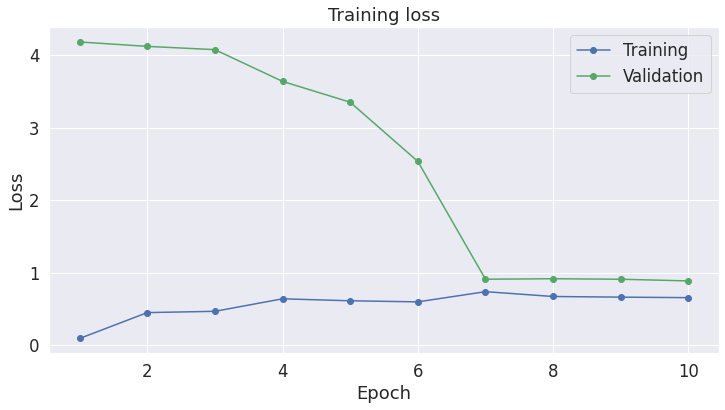

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams['figure.figsize'] = [12, 6]

df_stats = pd.DataFrame(data = training_stats)

df_stats = df_stats.set_index('epoch')

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
df_stats.to_csv(os.path.join(dir, 'amazon_individuality_augmented_stats.csv'))

label_experiment_idividuality_augmented = {
    "epochs": epochs,
    "train_batch_size" : train_batch,
    "valid_batch_size" : valid_batch,
    "initial_learning_rate": learning_rate,
     "max_sentence_length": max_length,
     "loss_fucntion": criterion,
     "optimizer": optimizer,

     "BERT output": "mean value of [cls] embeddings of non-padded token from the second to the last layer",
     "activation function": "relu",
     "dropout rate of BERT output": model_amazon.l2,
     "# of fully connected linear layer": 1,
     "dataset": "Amazon Review Augmented",
     "comment": "overfitting until epoch 7, then the 'gap' starts to decrease, which is good."
}

In [ ]:
import csv
with open(os.path.join(dir, 'amazon_individuality_augmented_config.csv'), 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in label_experiment_idividuality_augmented.items():
       writer.writerow([key, value])

## Evaluate the Model Performance

In [ ]:
model_amazon.eval()
predictions, labels = [], []
for step, batch in enumerate(valid_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  label = batch['label'].to('cpu').numpy()
  
  with torch.no_grad():
    prediction = model_amazon(input_ids, attention_mask)

  prediction = prediction.detach().cpu().numpy()
  predictions.append(prediction)
  labels.append(label)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
ac = []
for i in range(len(predictions)):
  ac_i = pred_accuracy(predictions[i], labels[i])
  ac.append(ac_i)
ac

[0.21875, 0.09375, 0.09375, 0.21875, 0.25, 0.0]

In [ ]:
predictions = np.asarray(predictions)
labels = np.asarray(labels)
predictions[0]

array([[0.61456484],
       [0.6145647 ],
       [0.6145648 ],
       [0.61456454],
       [0.6145648 ],
       [0.61456496],
       [0.6145649 ],
       [0.61456513],
       [0.61456484],
       [0.61456496],
       [0.6145648 ],
       [0.6145649 ],
       [0.6145648 ],
       [0.6145648 ],
       [0.6145649 ],
       [0.6145648 ],
       [0.6145648 ],
       [0.61456484],
       [0.6145649 ],
       [0.61456484],
       [0.6145648 ],
       [0.61456484],
       [0.6145647 ],
       [0.61456454],
       [0.61456484],
       [0.6145647 ],
       [0.6145648 ],
       [0.6145648 ],
       [0.6145648 ],
       [0.6145647 ],
       [0.6145649 ],
       [0.6145647 ]], dtype=float32)

In [ ]:
pred = np.concatenate(predictions, axis=0 )
pred = np.concatenate(pred, axis=0 )
pred = pred.reshape(len(pred),1)
print(pred.shape)

(166, 1)


In [ ]:
true_label = np.concatenate(labels, axis=0 )
true_label = true_label.reshape(len(true_label), 1)
print(true_label.shape)
type(true_label)

(166, 1)


numpy.ndarray

In [ ]:
df = np.concatenate([pred, true_label], axis = 1)
df = pd.DataFrame(data=df, columns=["preds", "labels"])
df

,preds,labels
0,0.614565,0.0
1,0.614565,0.0
2,0.614565,0.0
3,0.614565,0.0
4,0.614565,0.0
...,...,...
161,0.614565,0.0
162,0.614565,0.0
163,0.614565,0.0
164,0.614565,0.0


In [ ]:
sum((df["preds"]>=0.5) == df["labels"])

28

In [ ]:
df.loc[df.loc[df['labels'] == 1, :].idxmin()]

,preds,labels
15,0.614565,1.0
5,0.614565,1.0


In [ ]:
valid_raw.iloc[15,0]

"I replaced the bulb in my Hitachi 50VG825 LCD rear projection TV. The bulb was the original and I was surprised how long it lasted. When the bulb finally gave out, I didn't want to invest a lot in this older TV even though it is just like new. I saw bulbs from 29.00 shipped all the way up to the original Philips unit as high as 150.00. Since there are options with the case and without the case, I read the reviews and decided to forgo the case as most people ended up taking the bulb out of the case and putting it in their original case to get it to fit back in the tv properly. There are two wires that are attached with nuts to the bulb, on on the rear of the bulb and one on the side. Be careful with the one on the side. It is not as secure as the original bulb. Hold it firmly so it can't move and tighten securely. The new bulb was noticibly brighter, possibly because mine was so old. It is like having a new tv, even the colors are brighter. I am happy for now. I am interested to see ho

In [ ]:
df.loc[df['labels'] == 1, :].sort_values('preds')

,preds,labels
100,0.614565,1.0
102,0.614565,1.0
65,0.614565,1.0
40,0.614565,1.0
43,0.614565,1.0
147,0.614565,1.0
15,0.614565,1.0
135,0.614565,1.0
105,0.614565,1.0
134,0.614565,1.0


In [ ]:
df[df['labels']==1].preds.sort_values()[0:20]

100    0.614565
102    0.614565
65     0.614565
40     0.614565
43     0.614565
147    0.614565
15     0.614565
135    0.614565
105    0.614565
134    0.614565
154    0.614565
69     0.614565
89     0.614565
155    0.614565
8      0.614565
131    0.614565
143    0.614565
123    0.614565
158    0.614565
109    0.614565
Name: preds, dtype: float32

In [ ]:
valid_raw.iloc[100,0]

'It really is stylish for the price! Great buy!'

In [ ]:
df[df['labels'] == 0].sort_values('preds', ascending = False)

,preds,labels
160,0.614565,0.0
90,0.614565,0.0
7,0.614565,0.0
130,0.614565,0.0
163,0.614565,0.0
...,...,...
3,0.614565,0.0
23,0.614565,0.0
157,0.614565,0.0
72,0.614565,0.0


In [ ]:
valid_raw.iloc[160,0]

'Good'

# **Save and Load a Trained Model**

In [12]:
# check the tutorial here:
# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
import torch

# if you want to save the trained model for later evaluation (not for training)
#dir = "/content/drive/My Drive/" 
#torch.save(model_amazon.state_dict(), os.path.join(dir, 'amazon_individuality.pt'))

# later if you want to load the model and use it for evaluation (not trianing), do this: 
# the_model = TheModelClass(*args, **kwargs), in our case
model_amazon = AmazonBERT()

# and the_model.load_state_dict(torch.load(PATH)), note that path is specified above
model_amazon.load_state_dict(torch.load('/content/drive/My Drive/amazon_individuality.pt'))



<All keys matched successfully>

# **Prediction of New Amazon Reviews**

In [32]:
import pandas as pd
import numpy as np

In [27]:
current_reviews = pd.read_csv('all_reviews_v3.0.csv')

In [29]:
#current_reviews.dropna(subset=['text'],inplace=True)

In [30]:
current_reviews.shape

(135800, 14)

In [33]:
current_reviews['individuality'] = np.nan

In [35]:
current_reviews.head(5)

,index,asin,productTitle,countReviews,date,imageUrlList,numberOfHelpful,parentReviewId,rating,reviewId,text,title,username,category,individuality
0,1,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/16/2020,NaN,0,NaN,3,R385E1LP3AE40R,This Columbia jacket is a pretty good quality ...,Pretty good rain jacket,June B Furr,apparel,NaN
1,2,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/15/2020,NaN,0,NaN,5,R36I6DUHDK4HIB,Just as expected! Perfect rain jacket for todd...,Toddler approved,Meeko0924,apparel,NaN
2,3,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/14/2020,NaN,0,NaN,4,R4YTDBV1VENF6,I bought this for a Birthday gift and haven't ...,Birthday gift,Vera T.,apparel,NaN
3,4,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/11/2020,NaN,0,NaN,5,RMQ5B577OTPJY,This is perfect for those fall and spring days...,Good jacket,RD,apparel,NaN
4,5,B07R7DSBVH,"Columbia Boys' Big Glennaker Rain Jacket, Wate...",1571,7/10/2020,NaN,0,NaN,5,R12IYTDMAX94FD,good color,very good,ivy,apparel,NaN


In [36]:
current = pd.DataFrame(None)

current[['text','label']] = current_reviews[['text','individuality']]

In [37]:
current.head()

,text,label
0,This Columbia jacket is a pretty good quality ...,NaN
1,Just as expected! Perfect rain jacket for todd...,NaN
2,I bought this for a Birthday gift and haven't ...,NaN
3,This is perfect for those fall and spring days...,NaN
4,good color,NaN


In [38]:
current.shape

(135800, 2)

In [39]:
current[current['text'].isnull()].index.tolist()

[]

In [41]:
processed=AmazonDataset(current,tokenizer,max_length)

In [42]:
pred_sampler=SequentialSampler(processed)
pred_loader=DataLoader(processed,batch_size=valid_batch,num_workers=0)

In [43]:
model_amazon.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [44]:
model_amazon.eval()
predictions_2 = []
for step, batch in enumerate(pred_loader):
  input_ids = batch['input_ids'].squeeze().to(device, dtype = torch.long)
  attention_mask = batch['attention_mask'].squeeze().to(device, dtype = torch.long)
  
  with torch.no_grad():
    prediction_2 = model_amazon(input_ids, attention_mask)

  prediction_2 = prediction_2.detach().cpu().numpy()
  predictions_2.append(prediction_2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [45]:
predictions_2=np.asarray(predictions_2)
predictions_2[0]

array([[0.08325286],
       [0.01860385],
       [0.01413086],
       [0.09199511],
       [0.01158268],
       [0.02219386],
       [0.01161435],
       [0.02288337],
       [0.22461364],
       [0.03507054],
       [0.03755683],
       [0.05290414],
       [0.07917266],
       [0.02056381],
       [0.01179863],
       [0.03475101],
       [0.83978504],
       [0.14305831],
       [0.01945318],
       [0.0176475 ],
       [0.01739654],
       [0.02298952],
       [0.01978357],
       [0.01262799],
       [0.8833464 ],
       [0.2063604 ],
       [0.05278037],
       [0.01984112],
       [0.01210393],
       [0.03292012],
       [0.01571933],
       [0.02265069]], dtype=float32)

In [46]:
pred_3=np.concatenate(predictions_2,axis=0)
pred_3=np.concatenate(pred_3,axis=0)
pred_3=pred_3.reshape(len(pred_3),1)
print(pred_3.shape)

(135800, 1)


In [47]:
df_3=pd.DataFrame(data=pred_3,columns=['preds'])
df_3

,preds
0,0.083253
1,0.018604
2,0.014131
3,0.091995
4,0.011583
...,...
135795,0.059052
135796,0.137720
135797,0.019406
135798,0.014236


In [48]:
current_reviews['ind_pred']=df_3

In [50]:
current_reviews.head(5)
current_reviews.iloc[:,-1]

0         0.083253
1         0.018604
2         0.014131
3         0.091995
4         0.011583
            ...   
135795    0.059052
135796    0.137720
135797    0.019406
135798    0.014236
135799    0.015951
Name: ind_pred, Length: 135800, dtype: float32

In [ ]:
current_reviews.drop(columns=['individuality'],inplace=True)

In [ ]:
current_reviews.head(5)

In [54]:
current_reviews.to_csv(r'predicted_individuality_reviews.csv', index = False)

In [ ]:
df_3.sort_values(by='preds',ascending=False)

,preds
991,0.893028
2656,0.891034
117,0.890690
231,0.889333
56,0.888693
...,...
2546,0.011373
2895,0.011373
911,0.011360
1980,0.011356


In [ ]:
current.iloc[991,0]

'Perfect for hot summer workouts! I got the cobalt blue and itâ€™s even better looking in person, beautiful color. I ordered a medium and fits as expected, totally want to order kore!'

In [ ]:
current.iloc[2656,0]

'So far we are very happy with our new microwave. It is VERY quiet compared to our old one. It is very stylish and I love the black stainless steel door. Very modern looking also.'

In [ ]:
current.iloc[117,0]

'Got matching jackets for my husband and son for Christmas and they were great! Light weight, waterproof and super cute. Love it and will be buying in other colors as well'

In [ ]:
current.iloc[361,0]

'Well made. Fits well.'

In [ ]:
current.iloc[1980,0]

'Very good product'

In [ ]:
current.iloc[911,0]

'Too thin'

In [ ]:
df_3.iloc[2500,0]

0.012664562

In [ ]:
current.iloc[2500,0]

"I got one, which was not in working condition, the smart keypad wasn't functioning so I sent it back and got the replacement next day. But somehow not happy with the replacement also as sometime touchpad is not functioning and I need to push couple of times"

In [ ]:
current.iloc[991]

text     Perfect for hot summer workouts! I got the cob...
label                                                    1
Name: 991, dtype: object

In [ ]:
current.iloc[2656]

text     So far we are very happy with our new microwav...
label                                                    1
Name: 2656, dtype: object

In [ ]:
for ind in df_3.index:
  if df_3['preds'][ind] >= 0.5:
    current.label[ind]=1
  else:
    current.label[ind]=0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# **Cluster Analysis Usefulness - Apparel**

In [ ]:
import pandas as pd

In [ ]:
df1=pd.read_csv('amazon_data.csv')
df2=pd.read_csv('all_reviews.csv')

In [ ]:
df1=df1[(df1['helpful_votes'] > 0)]
df2=df2[(df2['numberOfHelpful'] > 0)]

In [ ]:
df1=df1[(df1['product_category'] == 'Apparel')]
df2=df2[(df2['category'] == 'apparel')]

In [ ]:
print(df1.shape)
print(df2.shape)

(93, 30)
(553, 16)


In [ ]:
df1.rename(columns={'review_body':'text'},inplace=True)

In [ ]:
apparel = pd.concat([df1,df2],ignore_index=True)

In [ ]:
apparel

,Unnamed: 0,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,text,review_date,social connectedness,environment,self_sufficiency,transparency_authenticity,tradition,individuality,diversity_equality,privacy,status,thrift_value,innovation,fun_adventure,health,Unnamed: 29,asin,productTitle,countReviews,date,imageUrlList,numberOfHelpful,parentReviewId,rating,reviewId,title,username,category,Individuality
0,5120532,US,67557.0,R1KSZIZUI25LXF,B002JLFMLK,109099956.0,Vedette Megane Firm Compression Sensual Corset...,Apparel,4.0,1.0,2.0,N,Y,I like this bodyshaper.,This body shaper does what it says. It makes y...,2013-09-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3620630,US,10055103.0,R3HZ4WB8L7URPG,B008G7JOBA,381781741.0,Carhartt Men's Sherpa Lined Sandstone Hooded M...,Apparel,5.0,3.0,3.0,N,Y,Size Small Means Medium,Other than the sizing that is bigger than the ...,2014-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1659497,US,30756407.0,R2SI835OV4RBJK,B00I3O0TEW,792622822.0,82 Days Women'S Rayon Span High & Low Short Sl...,Apparel,5.0,2.0,2.0,N,Y,Fits great! I'm 5'8 and 160 lb,Fits great! I'm 5'8 and 160 lb. Fit is a littl...,2015-02-21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1167952,US,40339143.0,R18SBMUFQMJCAJ,B00KIJ0V8Y,136638496.0,Fairy Tail Natsu Gray Lucy Hoodie Jacket Costume,Apparel,1.0,2.0,2.0,N,Y,DON'T BUY IF YOU'RE A LARGE,If you're normally a size large or higher DO N...,2015-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3283895,US,46317276.0,RP6M2GBW0COPL,B00A0L8TX4,129231363.0,Womens Fleece Lined Winter Leggings Many Color...,Apparel,1.0,1.0,1.0,N,Y,product was dry rotted,i received this product dry totted upon delive...,2013-11-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,2529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Love it, very comfortable. The color looked mo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B07PHJTGRL,RainbowTree Women's Pleated Tennis Skirt Elast...,54.0,9/22/2019,NaN,6.0,NaN,5.0,R1GJRCIY13JN78,Color off,Josiewi,apparel,NaN
642,2532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,What a cute LITTLE skirt!! LOVE this! I was ho...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B07PHJTGRL,RainbowTree Women's Pleated Tennis Skirt Elast...,54.0,8/30/2019,NaN,2.0,NaN,5.0,R32WMJLQNTAHZ5,Cute Tennis Skirt,kippy,apparel,NaN
643,2545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Well made. Fits beautifully. This print is ado...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B07PHJTGRL,RainbowTree Women's Pleated Tennis Skirt Elast...,54.0,7/11/2019,NaN,4.0,NaN,5.0,R4IHJP6ETRPC0,Adorable,MaryJane,apparel,NaN
644,2546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Comfortable fit and very flattering for tennis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B07PHJTGRL,RainbowTree Women's Pleated Tennis Skirt Elast...,54.0,7/6/2019,NaN,2.0,NaN,5.0,R207LD2DW9YAM7,Active in Lou,Jan,apparel,NaN


In [ ]:
apparel = apparel.text

In [ ]:
apparel

0      This body shaper does what it says. It makes y...
1      Other than the sizing that is bigger than the ...
2      Fits great! I'm 5'8 and 160 lb. Fit is a littl...
3      If you're normally a size large or higher DO N...
4      i received this product dry totted upon delive...
                             ...                        
641    Love it, very comfortable. The color looked mo...
642    What a cute LITTLE skirt!! LOVE this! I was ho...
643    Well made. Fits beautifully. This print is ado...
644    Comfortable fit and very flattering for tennis...
645                          Nice fit, very comfortable.
Name: text, Length: 646, dtype: object

In [ ]:
apparel.shape

(646,)

In [ ]:
apparel = pd.DataFrame(apparel)

In [ ]:
inter_output = {}
def get_inter_output(name):
    def hook(model, input, output):
        inter_output[name] = output[0].detach()
    return hook

handle = model_amazon.l1.register_forward_hook(get_inter_output('l1'))

In [ ]:
model_amazon(input_ids,attention_mask)

tensor([[0.2399],
        [0.0218],
        [0.9446],
        [0.9096],
        [0.0155],
        [0.0119]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
handle.remove()

In [ ]:
len(inter_output)

1

In [ ]:
inter_output['l1'].shape

torch.Size([6, 128, 768])

In [ ]:
model_test = AmazonBERT()
model_test.to(device)

AmazonBERT(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
handle.remove()

In [ ]:
 inter_output["l1"][:, 0 : attention_mask.sum(), :].mean(dim = 1).shape

torch.Size([6, 768])

In [ ]:
model_amazon.named_modules()

<generator object Module.named_modules at 0x7f6ff08c4410>

In [ ]:
# first, let's convert the raw review texts into contextualized numerical embeddings 
# using encode_plus and BERT model

def text_to_embedding(index, dataset, max_len):
  # argument input: is the index to locate a specific text reivew
  # argument dataset: is the dataset that containing text reviews
  # argument max_len: is the max length of each review, for padding or truncating 
  
  # extract the review text column in the dataset
  # per my experience, extract a column and then using pd.iloc[index] on the column
  # experience less bugs than pd.loc[index, 'column name']
  reviews = dataset.text

  # get the text review
  text = reviews.iloc[index]
  # transfer the text reivew into input_ids and attentino_mask that are required for BERT model
  encoded_text = tokenizer.encode_plus(
      text,
      max_length = max_len,
      # note that in some versions of transformer in you local machine, the code is 
      # pad_to_max_length = True,
      # truncation_strategy = 'longest_first',
      # we might need to change the argument name a little to fit different version of transformers
      padding = "max_length",
      truncation = "longest_first",
      add_special_tokens = True,
      return_tensors = "pt"
  )
  # make the input_ids and attention_mask into torch tensors, 
  # which will make the late use of BERT Model easier
  # note that we use to(device) to deliever the data to GPU, 
  # so that they can be used in model_yelp, which is alread in GPU
  input_ids = torch.tensor(encoded_text['input_ids'], dtype = torch.long).to(device)
  attention_mask = torch.tensor(encoded_text['attention_mask'], dtype = torch.long).to(device)
  
  # transfer the input_ids and attention_mask into sentence embeddings by
  # putting them into our trained NN model: mddel_yelp
  model_amazon(input_ids, attention_mask)
 
  
  text_embedding = inter_output["l1"][:, 0 : attention_mask.sum(), :].mean(dim = 1)
  # again, we can choose to use differnt outputs from the BERT Model as the embeddings of the sentence/review
  # here, we use the mean value of non-padded tokens from the last self-attention layer of BERT  
  
  return text_embedding



In [ ]:
text_to_embedding(32, apparel, 128).shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([6, 768])

In [ ]:
review_embeddings = []
with torch.no_grad():
  for index in range(200):
    review_embedding = text_to_embedding(index, apparel, 128)
    review_embeddings.append(review_embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
usefulness_embeddings = torch.cat(review_embeddings, 0)
usefulness_embeddings = usefulness_embeddings.to('cpu')
usefulness_embeddings = usefulness_embeddings.numpy()

In [ ]:
type(usefulness_embeddings)

numpy.ndarray

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np

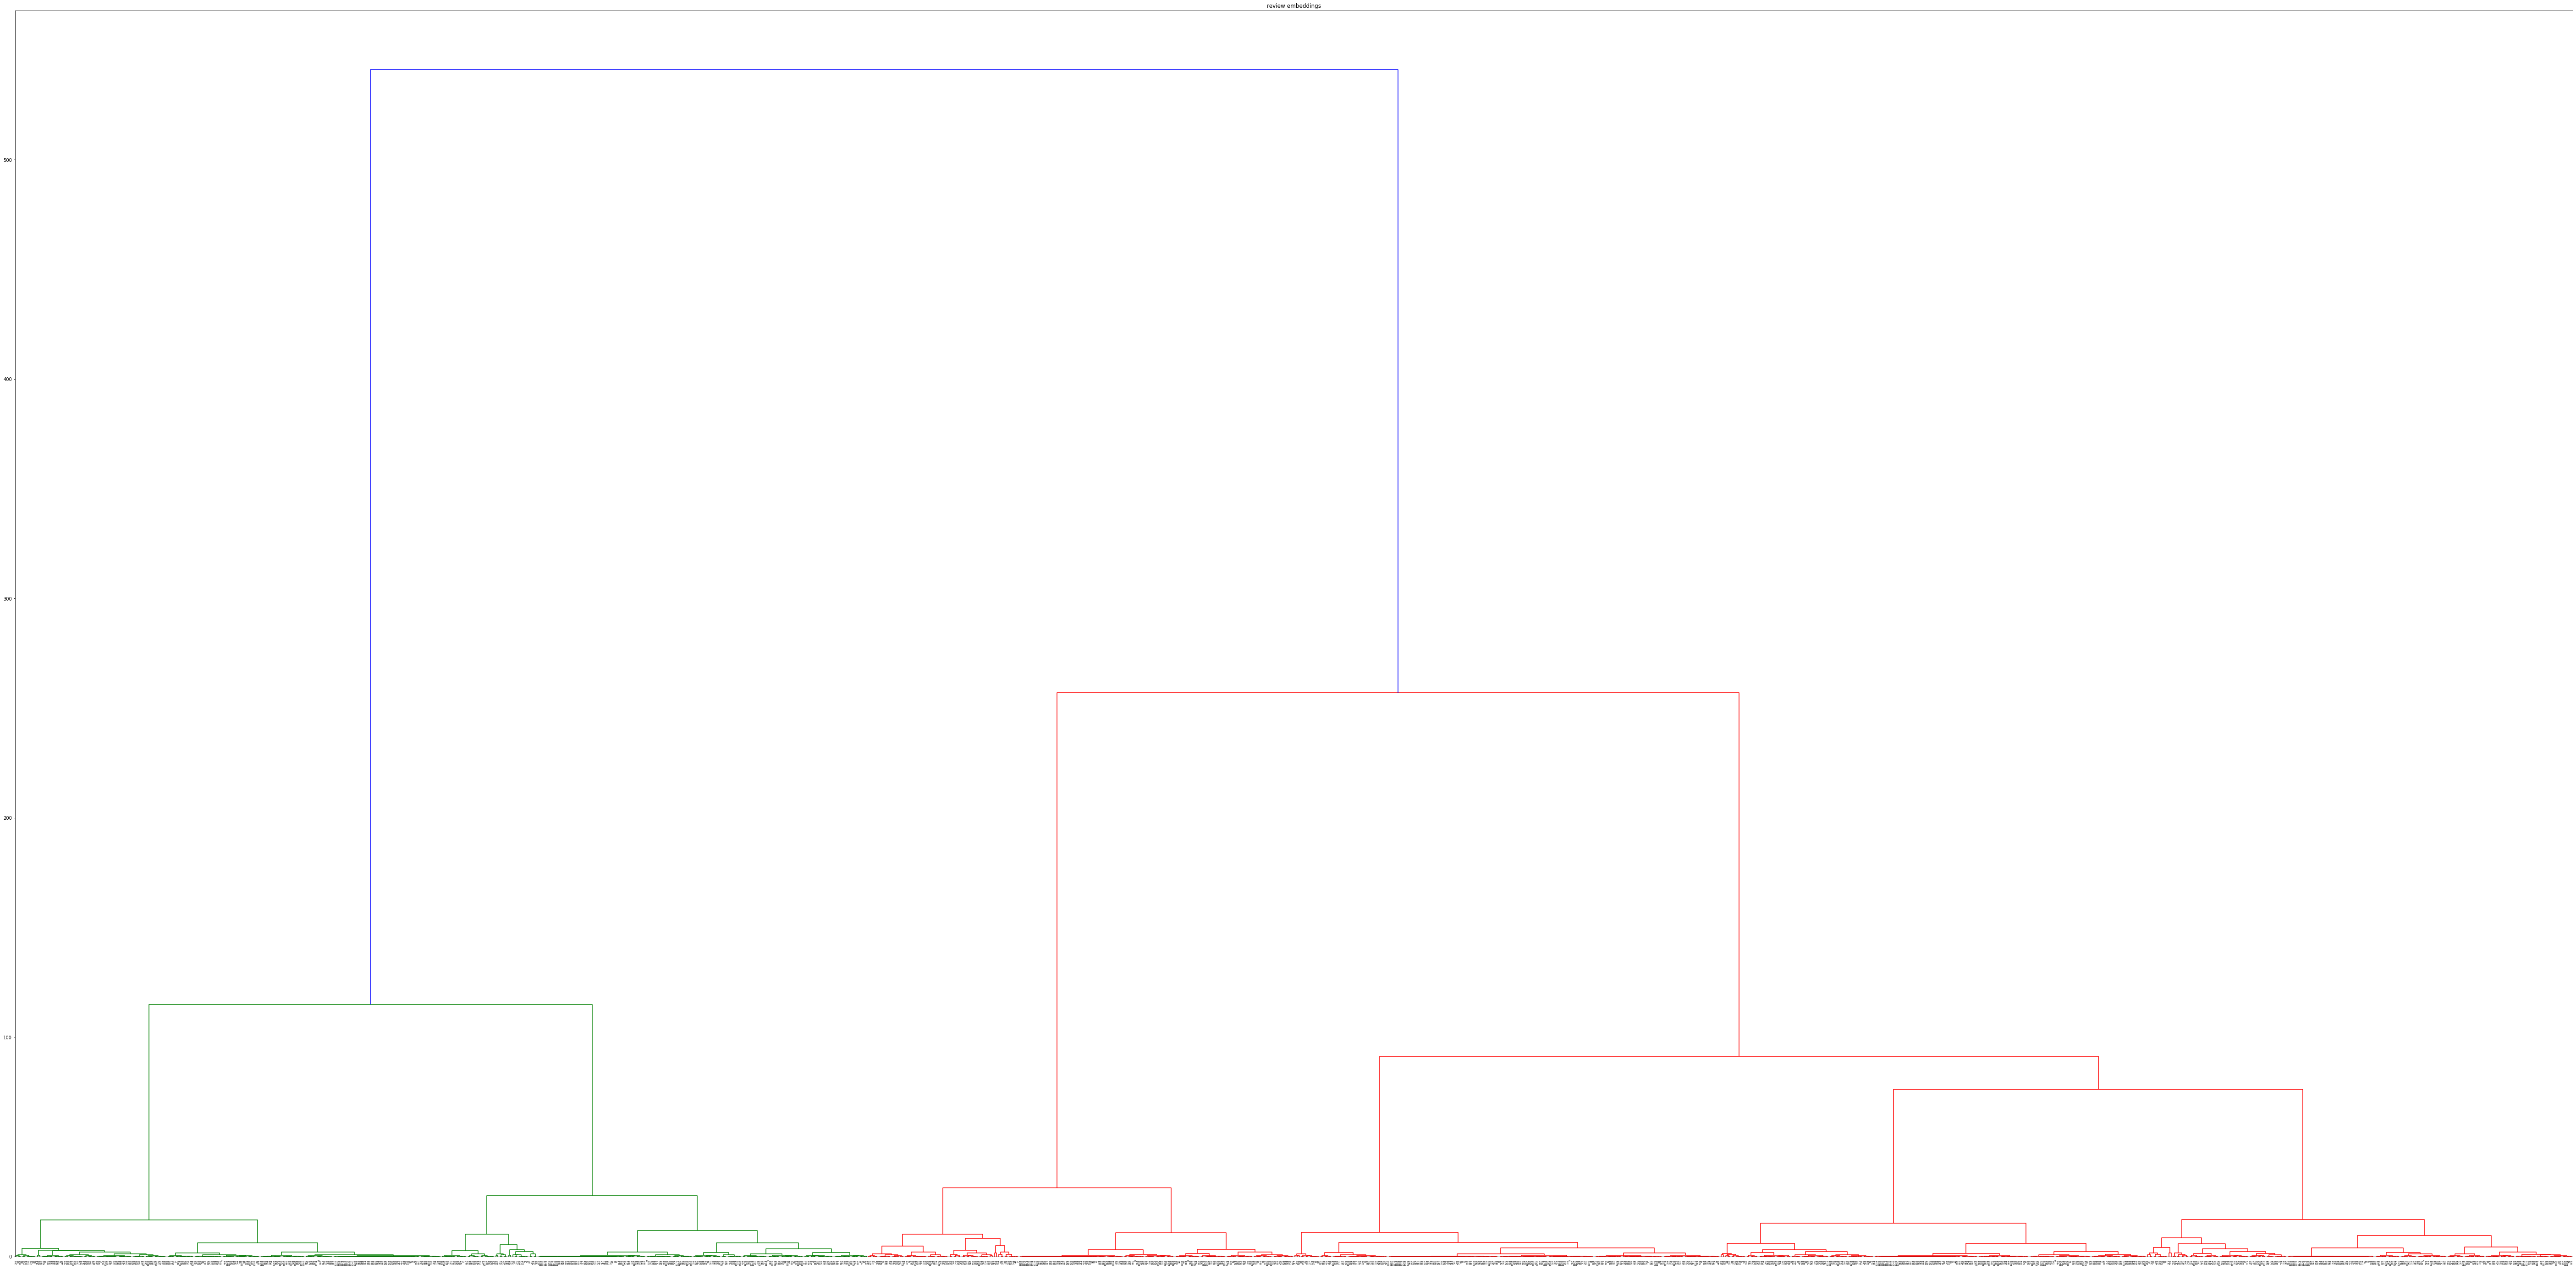

In [ ]:
import scipy.cluster.hierarchy as shc 
plt.figure(figsize = (100, 50))
plt.title("review embeddings")
dend = shc.dendrogram(shc.linkage(usefulness_embeddings, method = "ward"))

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')

In [ ]:
cluster_id = cluster.fit_predict(usefulness_embeddings)

In [ ]:
cluster_id

array([2, 1, 0, ..., 0, 1, 1])

In [ ]:
sample_review = apparel.iloc[0:200 ,:]
sample_review['cluster_id'] = pd.Series(cluster_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sample_review

,text,cluster_id
0,This body shaper does what it says. It makes y...,2
1,Other than the sizing that is bigger than the ...,1
2,Fits great! I'm 5'8 and 160 lb. Fit is a littl...,0
3,If you're normally a size large or higher DO N...,0
4,i received this product dry totted upon delive...,1
...,...,...
195,"I absolutely love this tank, and will be order...",0
196,I bought this as an experiment. It seemed to i...,1
197,This shirt is super comfy. I got it for doing ...,1
198,WAY too small. The reviews are super mixed so ...,2


In [ ]:
sample = sample_review.groupby('cluster_id').apply(pd.DataFrame.sample, 1).iloc[:,0]

In [ ]:
sample

cluster_id    
0           38                     Great fit. Great quality so far!
1           82    I have had trouble finding women's sox that ac...
2           96    I bought this for my 11 yr old son for our Nat...
Name: text, dtype: object

In [ ]:
sample_review.iloc[38,0]

'Great fit. Great quality so far!'

In [ ]:
sample_review.iloc[82,0]

"I have had trouble finding women's sox that actually fit. These fit my foot perfectly and the band does not constrict my calf. Warm and toasty, great colors they are made well."

In [ ]:
sample_review.iloc[96,0]

"I bought this for my 11 yr old son for our Nat'l Park RV trip a couple weeks ago. It was the perfect layer he needed to wear alone on 60 degree days with a tee and to have over his Nano on chillier days. It's super lightweight to stuff in the pack or tie around waist and excellent quality. Never used it in a downpour but shed the water under the falls in Zion!"

In [ ]:
sample

cluster_id     
0           93     Im not sure what the legal definition of "wate...
1           119    We received this a few weeks ago and it was in...
2           174    My big thing was them being see through. They ...
Name: text, dtype: object

In [ ]:
sample_review.iloc[93,0]

'Im not sure what the legal definition of "waterproof" is but when it comes to jackets I think it should mean actually waterproof. This needs to be sold as a water resistant jacket.'

In [ ]:
sample_review.iloc[119,0]

"We received this a few weeks ago and it was in great shape on arrival. We just got to really put it to the test this morning. We got a solid downpour while my son needed to walk to the bus stop. I was soaked to the bone and his pants were soaked through, but his top half, covered by this jacket, was bone dry. Even the hair that hangs down in his face a little was dry, so the hood is effective. The jacket is made of one layer of material and protects against rain and wind. It's hot and humid here, so I wouldn't know if it fends off the cold well. My son is quite tall for his age (7 years and 53 inches) and the medium fits well. It may fit through next summer too. I'll gladly buy another when he outgrows this one."

In [ ]:
sample_review.iloc[174,0]

'My big thing was them being see through. They are not and the material is light and the medium fit perfect. Very happy with my purchase'

In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


# **Cluster Analysis Usefulness - Electronic**

In [ ]:
electronic = pd.read_csv('electronic_usefulness.csv')

In [ ]:
electronic.rename(columns={'review_body':'text'},inplace=True)

In [ ]:
electronic = electronic.text

In [ ]:
electronic = pd.DataFrame(electronic)

In [ ]:
electronic

,text
0,"We don't use it in the shower, but it is in our bathroom. Volume is loud and clear and reception is great. I really like the portability of the unit as well. I would buy this again."
1,I have a difficult hearing and these help a lot
2,"I almost never buy a product which doesn't have a decent review written about it anywhere online, but I decided to take a chance with these cans. Briefly, the noise cancelling works extremely well, they're comfortable, and they fold up into a very small package for being over the ear phones (with my ears, anyways). That said, I was very disappointed with the sound quality when the noise cancelling was turned off, although when turned on they sound really good on the low end, even if the highs are somewhat muted. My only concern at this point is how long the batteries will last since there's no way I'm going to use these without the noise cancelling turned on."
3,"Received this replacement battery for my rechargeable lantern yesterday. Had time today to install it and had a little bit of charge and it worked. Lantern is handy and was thankful there was a replacement. Shipping was excellent and cannot think of anything negative about this product. If anyone is interested, this battery has push in terminals like what you can find on ur car."
4,"I've been looking for some headphones to run with for a while and I've tried several different models. Many haven't stayed put and others made a lot of noise through the cord (e.g., BOOM BOOM transferred through the cord with each step). The PMX70 is great! The sound is superb and they stay put."
...,...
293,"I was dealing with bad insomnia for the past few months, and my efforts to wake earlier (so I'd be tired enough to sleep earlier) were not helped by me constantly sleeping through my alarm. I was looking for a clock with a few specific functions: 1. It had to have a gradual wake feature, as the shock from normal alarm clocks always left me groggy in the morning, 2. It had to be able to use some kind of nature sound as the alarm, simply because it's more pleasant to wake up to those than it is to a beep, and 3. It had to be lit with cool blue LED lights, because this is less jarring to look at at night, and the blue is more soothing to look at than the normal red LEDs, which just look ugly to me.<br /><br />It was really impressed with how many sounds there were on the clock (20), I didn't expect it to have that many. I've never heard the earlier model so I can't comment if the clarity was better with those, but the sounds are fine to use as an alarm. They are definitely not clear enough to use as a sound machine or sound soother; there is a lot of noise, like the sounds were recorded through a cheap microphone, or possibly the speakers are cheap. But since I did not buy the alarm clock to listen to, and just use it as an alarm, it personally did not matter to me.<br /><br />Some of the sounds are also pretty clear. I like to use the wind chimes sound as my alarm, since it's a gentle way to wake up, and the sound clarity is better than some of the other sounds like the ocean or the brook.<br /><br />It's very easy and straightforward to navigate the clock menus and set up the alarm. You can also program 2 alarms, which is a nice bonus! And you can set each alarm to go off everyday, every weekday, or every weekend day. I was impressed with how many features the clock was programmed with.<br /><br />My insomnia is also a lot better now, and this clock looks great on my blue desk! It had an unobtrusive yet slick and modern design, and the numbers have 3 levels of brightness that are all aesthetically pleasing. There is also a daylight savings time button on the back of the clock, so you can adjust that with the flick of a finger instead of programming it through the clock buttons manually.<br /><br />I am happy with my purchase and glad I bought it despite the negative reviews. :) There really wasn't any other alarm clock on Amazon that fit my crit

In [ ]:
electronic.shape

(298, 1)

In [ ]:
review_embeddings = []
with torch.no_grad():
  for index in range(200):
    review_embedding = text_to_embedding(index, electronic, 128)
    review_embeddings.append(review_embedding)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
usefulness_embeddings = torch.cat(review_embeddings, 0)
usefulness_embeddings = usefulness_embeddings.to('cpu')
usefulness_embeddings = usefulness_embeddings.numpy()

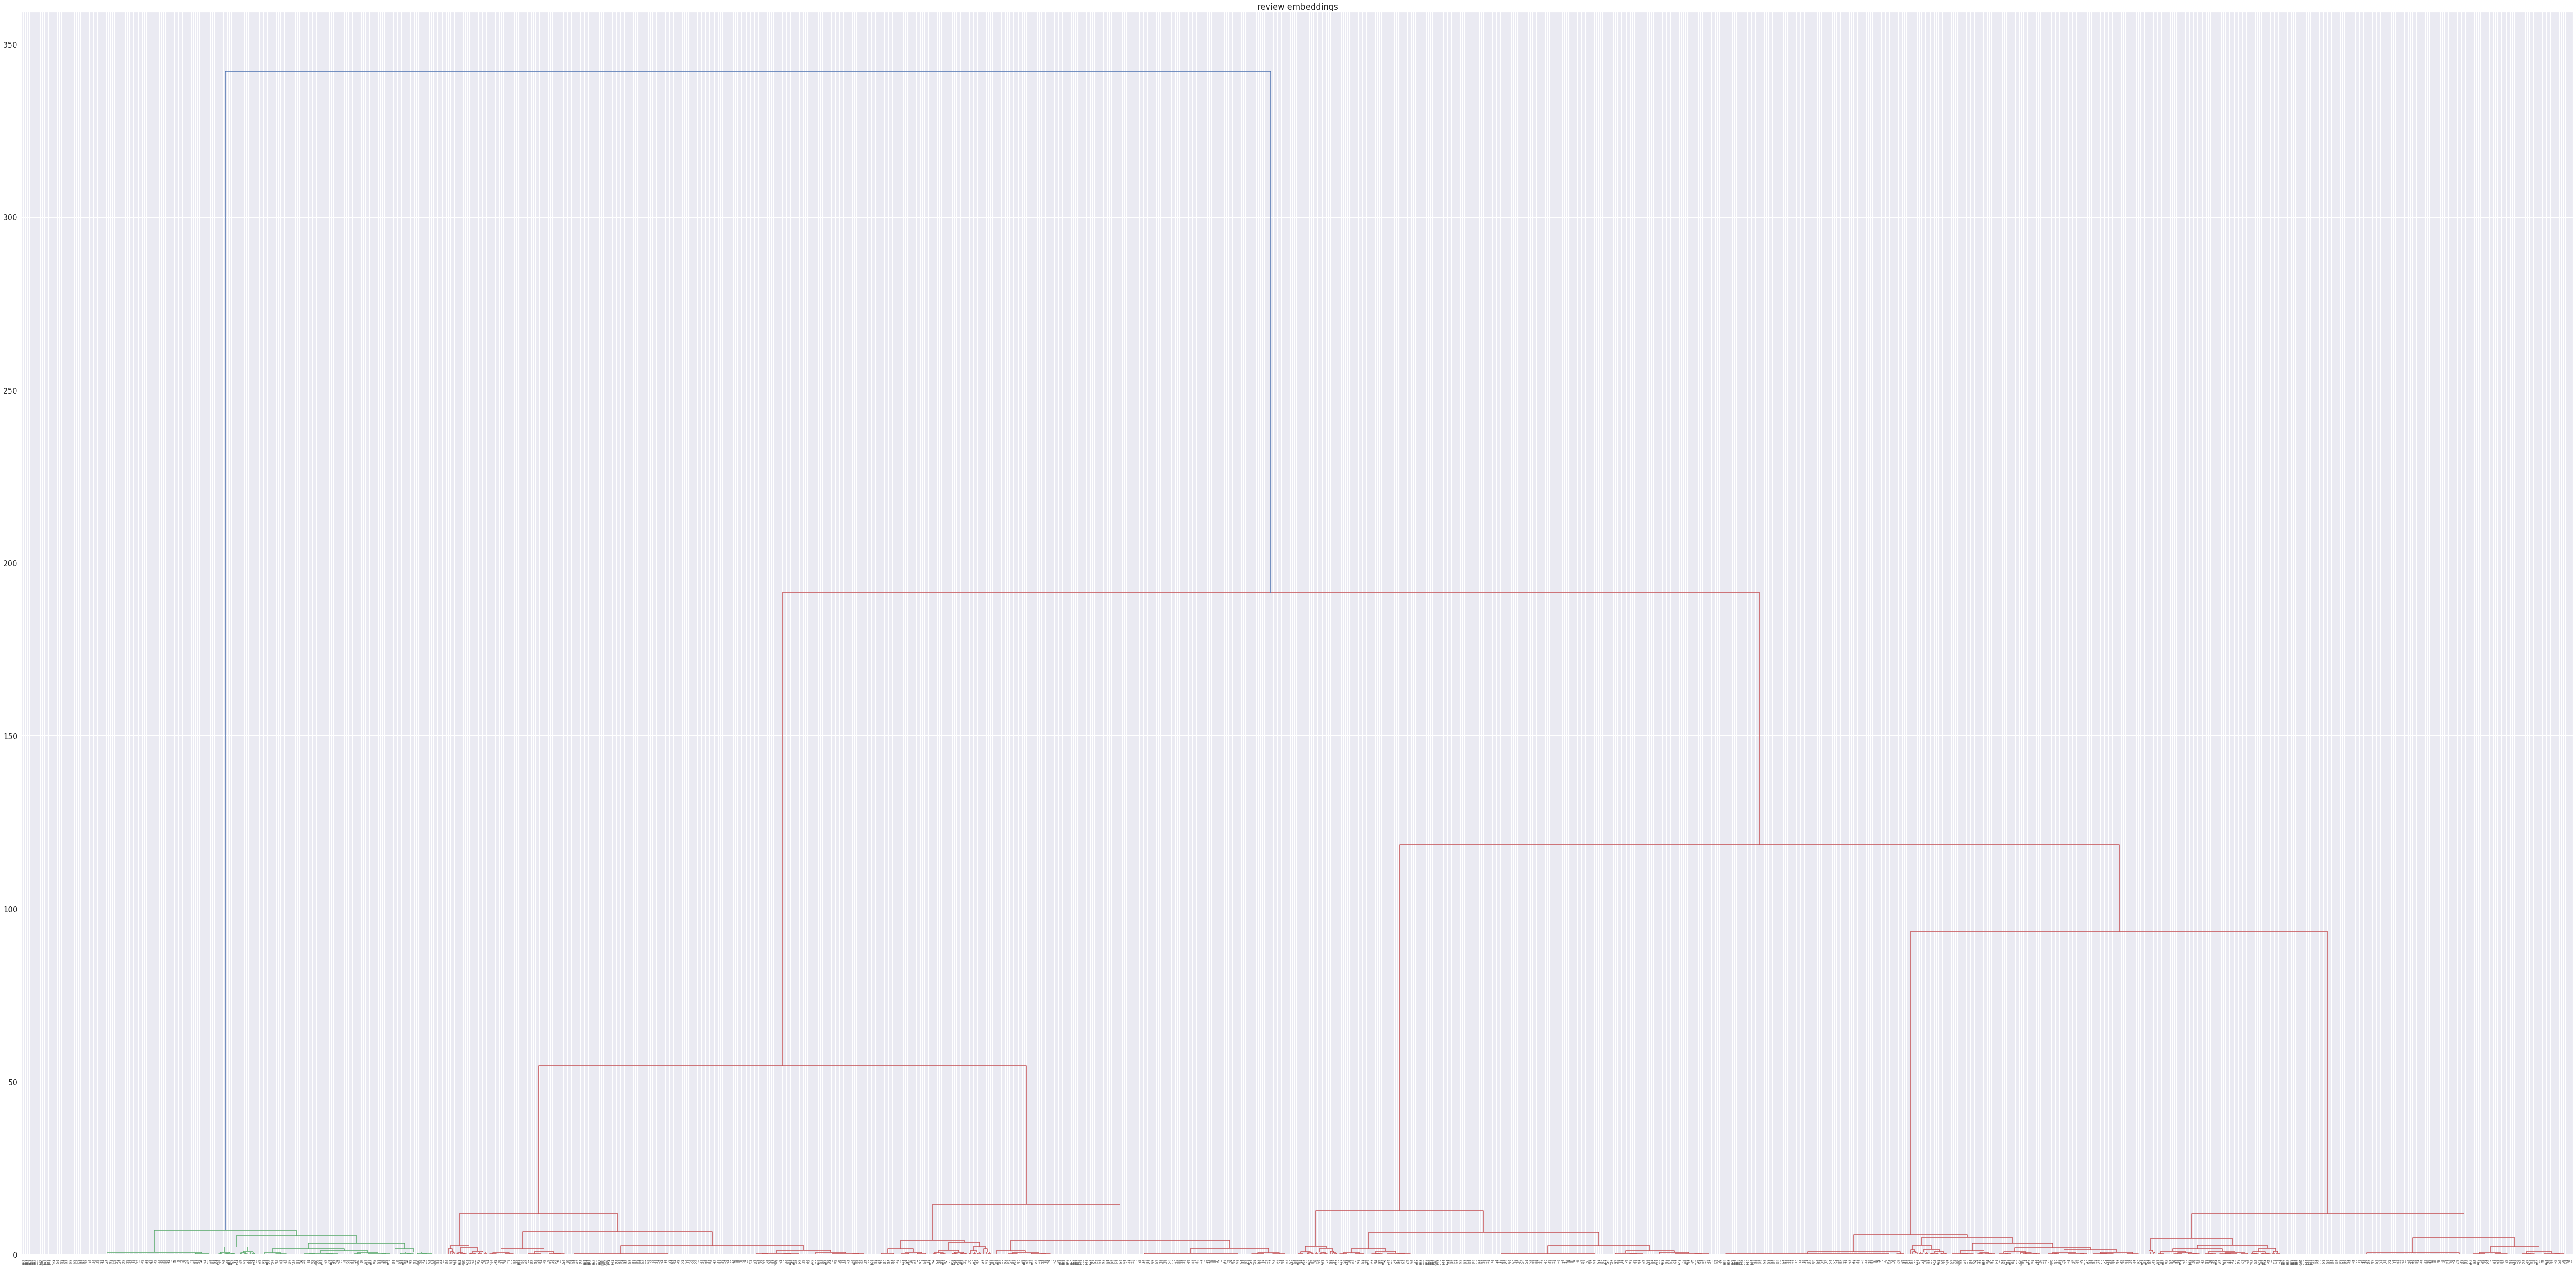

In [ ]:
plt.figure(figsize = (100, 50))
plt.title("review embeddings")
dend = shc.dendrogram(shc.linkage(usefulness_embeddings, method = "ward"))

In [ ]:
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')

In [ ]:
cluster_id = cluster.fit_predict(usefulness_embeddings)

In [ ]:
sample_review = electronic.iloc[0:200 ,:]
sample_review['cluster_id'] = pd.Series(cluster_id)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sample_review

,text,cluster_id
0,"We don't use it in the shower, but it is in our bathroom. Volume is loud and clear and reception is great. I really like the portability of the unit as well. I would buy this again.",1
1,I have a difficult hearing and these help a lot,0
2,"I almost never buy a product which doesn't have a decent review written about it anywhere online, but I decided to take a chance with these cans. Briefly, the noise cancelling works extremely well, they're comfortable, and they fold up into a very small package for being over the ear phones (with my ears, anyways). That said, I was very disappointed with the sound quality when the noise cancelling was turned off, although when turned on they sound really good on the low end, even if the highs are somewhat muted. My only concern at this point is how long the batteries will last since there's no way I'm going to use these without the noise cancelling turned on.",0
3,"Received this replacement battery for my rechargeable lantern yesterday. Had time today to install it and had a little bit of charge and it worked. Lantern is handy and was thankful there was a replacement. Shipping was excellent and cannot think of anything negative about this product. If anyone is interested, this battery has push in terminals like what you can find on ur car.",0
4,"I've been looking for some headphones to run with for a while and I've tried several different models. Many haven't stayed put and others made a lot of noise through the cord (e.g., BOOM BOOM transferred through the cord with each step). The PMX70 is great! The sound is superb and they stay put.",2
...,...,...
195,"I love it! I just listened while watching on TV to a baseball game(A's vs SF Giants) of course my team yhe A's lost. I loved listening while dh played the piano and even talked on the phone and the TV was muted and we both enjoyed the game lol<br /><br />The volume buttons are easy enough to use, and turning it off was easy too. Not sure if I was exercising it would be as easy. I use my iPod for that I'm sure if I needed to I would use the headphones. It was a little tight but maybe there are instructions, I didn't read too closely, to loosen them. I love wireless don't you?<br /><br />The dh listened to music on the TV this morning also and really liked the sound of the music. I may get brave enough to try my iPod with it too. It was a Bluetooth hookup too.<br /><br />I'm looking forward to all the uses I'll get to use the headset for. The headphones were packaged interestingly--what a great plastic box! Grandson will probably have a good time with it lol",0
196,"I often mount LCD TV's in bars and restaurants. I have used all the brands of mounts. This one is the best and easiest to install I have encountered. The built in bubble level and hook for the cords are are really great! If you want a mount, but this mount. EasyMount is the only brand I now use professionally.",2
197,These headphones are amazing! They are great and worth the price and they are perfect for studying or working and do not want to he disturbed,2
198,"Used these for some long flights between Tokyo and Chicago, the noise canceling was antiquate and the sound quality for listening to music and movies was much improved over the airline provided headphones. These really blocked out the dine of the engines and cabin noise.",1


In [ ]:
sample = sample_review.groupby('cluster_id').apply(pd.DataFrame.sample, 1).iloc[:,0]

In [ ]:
sample

cluster_id     
0           97     it looks very well made and looks good too sitting under the computer desk with its colorful backlit. another great product from monster as long you buy it at a discounted price                              
1           102    Returned                                                                                                                                                                                                       
2           143    USB ports failed upon receipt, not sure if I should give it a second try.<br />If you are lucky to get a good one, it should be an ideal solution for someone like me who owns iPad and another Samsung tablet.
Name: text, dtype: object

In [ ]:
sample

cluster_id    
0           85    Completely misleading. It's not an auto set clock. Mine wasn't set, and is so cheap I can't even set the time. Piece of junk!                                                        
1           96    It didn't really work like how I wanted it too. For example when I plugged in two headphones they would receive only half the volume.                                                
2           23    This the third HDR120 I've purchased. I'am totally convinced on it's superior performance and quality. I have three HiFI Wireless headsets connected to three video or music systems.
Name: text, dtype: object

In [ ]:
sample

cluster_id     
0           31     I saw these at an airport tech store and gave them a listen Great sound but high priced for an impulse buy so I held off. While waiting for my flight, I decided to check out Amazon reviews and pricing. I was impressed by both so I ordered the Jammin' Positive Vibration headphones. Amazon pricing is great!! I am still really impressed by the sound quality. The only thing that I don't like is the relatively thin padding and the small degree of adjustment available for the size of the head. I don't have a big head, my friends might say otherwise, and I can get them adjusted but I notice the thin padding. Anyway, great for mowing the lawn and other outdoor work!! Great deal and I recommend them to anyone!                                                                                                                                                                                                                                                               

In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.
